In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore
from scipy.special import logit
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

%run -i '../analysis_utils.py'
%run -i '~/psix/utils/psix_functions.py'
%run -i '~/psix/utils/utils_functions.py'

100%|██████████| 202/202 [00:01<00:00, 183.42it/s]


Text(0.5, 0, 'feature selection')

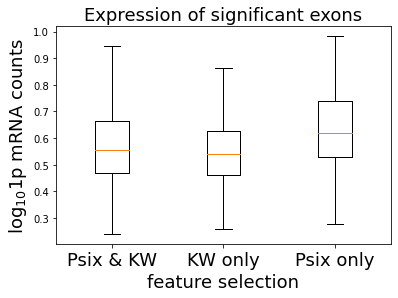

In [2]:
psix_pos = tiklova_psix.index[(tiklova_psix.qvals <= 0.05)]
kw_pos = tiklova_kw.index[(tiklova_kw.qvals <= 0.05)]
kw_only_pos = [x for x in kw_pos if x not in psix_pos]
psix_only_pos = [x for x in psix_pos if x not in kw_pos]

plt.boxplot(
    [np.log10(tiklova_mrna_event.loc[kw_pos | psix_pos]+1).mean(axis=1),
     np.log10(tiklova_mrna_event.loc[kw_only_pos]+1).mean(axis=1).dropna(),
     np.log10(tiklova_mrna_event.loc[psix_only_pos]+1).mean(axis=1).dropna()], showfliers=False)
plt.xticks([1, 2, 3], ['Psix & KW', 'KW only', 'Psix only'], fontsize=18)
plt.ylabel('log$_{10}$1p mRNA counts', fontsize=18)
plt.title('Expression of significant exons', fontsize=18)
plt.xlabel('feature selection', fontsize=18)

Text(0.5, 0, 'feature selection')

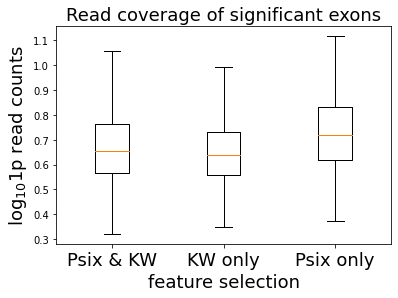

In [3]:
psix_pos = tiklova_psix.index[(tiklova_psix.qvals <= 0.05)]
kw_pos = tiklova_kw.index[(tiklova_kw.qvals <= 0.05)]
kw_only_pos = [x for x in kw_pos if x not in psix_pos]
psix_only_pos = [x for x in psix_pos if x not in kw_pos]

plt.boxplot(
    [np.log10(tiklova_sj_reads_adjusted.loc[kw_pos | psix_pos]+1).mean(axis=1),
     np.log10(tiklova_sj_reads_adjusted.loc[kw_only_pos]+1).mean(axis=1).dropna(),
     np.log10(tiklova_sj_reads_adjusted.loc[psix_only_pos]+1).mean(axis=1).dropna()], showfliers=False)
plt.xticks([1, 2, 3], ['Psix & KW', 'KW only', 'Psix only'], fontsize=18)
plt.ylabel('log$_{10}$1p read counts', fontsize=18)
plt.title('Read coverage of significant exons', fontsize=18)
plt.xlabel('feature selection', fontsize=18)

In [8]:
psix_comparison = pd.read_csv('tables/tiklova_psix_comparison.tab',
                           sep='\t', index_col=0)
psix_comparison_pvals = pd.read_csv('tables/tiklova_psix_comparison_pvals.tab',
                               sep='\t', index_col=0)

kw_comparison = pd.read_csv('tables/tiklova_kw_comparison.tab', sep='\t', index_col=0)
kw_comparison_pvals = pd.read_csv('tables/tiklova_kw_comparison_pvals.tab', sep='\t', index_col=0)


psix_comparison = psix_comparison[[str(x) for x in range(11)]]
psix_comparison_pvals = psix_comparison_pvals[[str(x) for x in range(11)]]

kw_comparison = kw_comparison[[str(x) for x in range(11)]]
kw_comparison_pvals = kw_comparison_pvals[[str(x) for x in range(11)]]

kw_comparison = kw_comparison.mask(psix_comparison.isna())
kw_comparison_pvals = kw_comparison_pvals.mask(psix_comparison_pvals.isna())

psix_comparison_z = psix_comparison.copy()
kw_comparison_z = kw_comparison.copy()

for bucket in [str(y) for y in range(11)]:
    x = psix_comparison[bucket].dropna().index
    z = zscore(psix_comparison[bucket].dropna())

    for i in range(len(x)):
        psix_comparison_z.loc[x[i], bucket] = z[i]

    x = kw_comparison[bucket].dropna().index
    z = zscore(kw_comparison[bucket].dropna())

    for i in range(len(x)):
        kw_comparison_z.loc[x[i], bucket] = z[i]

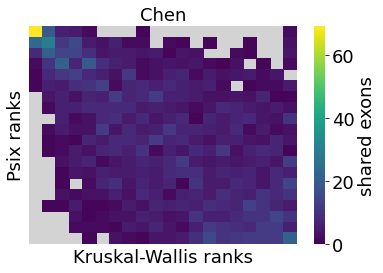

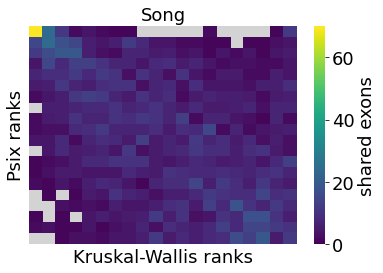

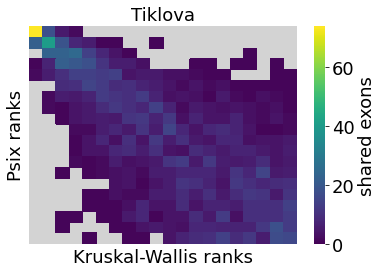

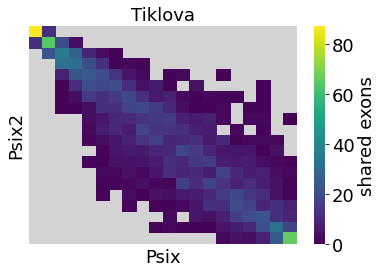

In [9]:
chen_comparison, chen_comparison_exons = plot_ranks(chen_kw, chen_psix, 'KW_score', 'L_score', bins=20, 
                                          name1='Kruskal-Wallis ranks', name2='Psix ranks', title='Chen')

song_comparison, song_comparison_exons = plot_ranks(song_kw, song_psix, 'KW_score', 'L_score', bins=20, 
                                          name1='Kruskal-Wallis ranks', name2='Psix ranks', title='Song')

tiklova_comparison, tiklova_comparison_exons = plot_ranks(tiklova_kw, tiklova_psix, 'KW_score', 'L_score', bins=20, 
                                          name1='Kruskal-Wallis ranks', name2='Psix ranks', title='Tiklova')


tiklova_comparison2, tiklova_comparison_exons2 = plot_ranks(tiklova_psix, tiklova_psix2, 'L_score', 'L_score', bins=20, 
                                          name1='Psix', name2='Psix2', title='Tiklova')

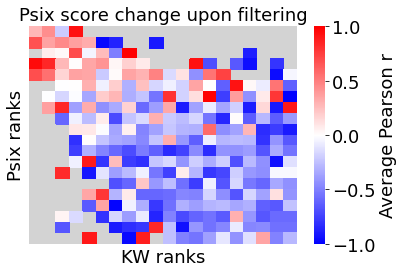

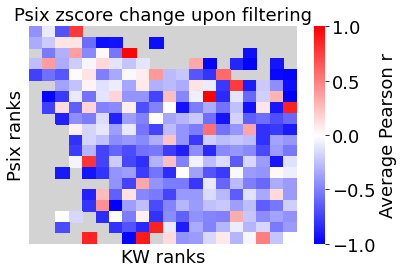

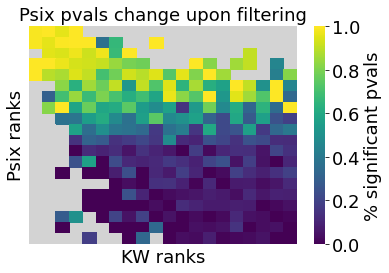

In [10]:
plot_correlations_per_rank(psix_comparison, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='Psix score change upon filtering')

plot_correlations_per_rank(psix_comparison_z, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='Psix zscore change upon filtering')

plot_correlations_per_rank(psix_comparison_pvals, tiklova_comparison_exons, tiklova_comparison, method = 'pvalues', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='Psix pvals change upon filtering')

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [32]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

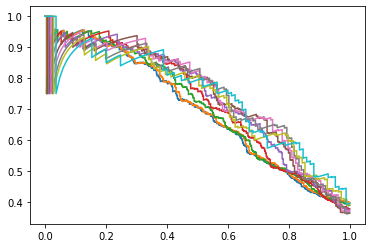

In [34]:
weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

# exons

for i in range(1, 11):
    
    exons = psix_comparison_pvals[str(i)].dropna().index & (weyn_pos | weyn_neg)
    significant_exons = weyn_pos & exons
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_psix = np.array(psix_comparison.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_psix)
    plt.plot(rec, pre)

In [37]:
from sklearn.metrics import auc

psix_auc = []
kw_auc = []

for i in range(1, 11):
    
    exons = psix_comparison_pvals[str(i)].dropna().index & (weyn_pos | weyn_neg)
    exons_pos = weyn_pos & exons
    exons_neg = weyn_neg & exons
    
    psix_i_list = []
    kw_i_list = []


    for sample in tqdm(range(200)):

        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
        y_true = [1]*len(pos_choice) + [0]*len(neg_choice)
        y_psix = np.array(psix_comparison.loc[list(pos_choice) + list(neg_choice), '0'])
        pre, rec, thres = precision_recall_curve(y_true, y_psix)
        psix_i_list.append(auc(rec, pre))
        
        
        
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
        y_true = [1]*len(pos_choice) + [0]*len(neg_choice)
        y_kw = np.array(kw_comparison.loc[list(pos_choice) + list(neg_choice), '0'])
        pre, rec, thres = precision_recall_curve(y_true, y_kw)
        kw_i_list.append(auc(rec, pre))


    psix_auc.append(psix_i_list)
    kw_auc.append(kw_i_list)

100%|██████████| 200/200 [00:00<00:00, 330.50it/s]


Text(0.5, 1.0, 'Method comparison')

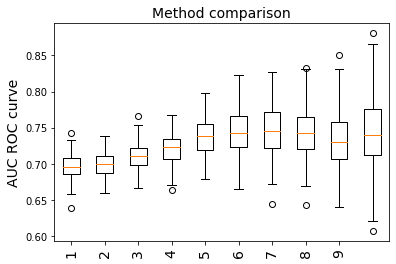

In [40]:
bp = plt.boxplot(psix_auc)

plt.xticks(np.arange(1, len(psix_auc)), [str(x) for x in range(1, 11)], fontsize=14, rotation=90)

plt.ylabel('AUC ROC curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)

Text(0.5, 1.0, 'Method comparison')

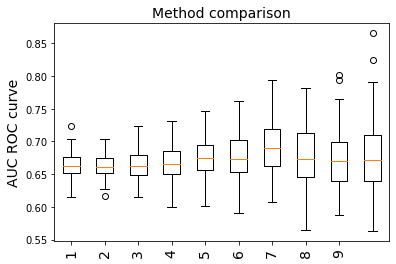

In [41]:
bp = plt.boxplot(kw_auc)

plt.xticks(np.arange(1, len(kw_auc)), [str(x) for x in range(1, 11)], fontsize=14, rotation=90)

plt.ylabel('AUC ROC curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)

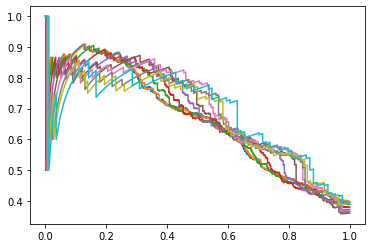

In [35]:
weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

# exons

for i in range(1, 11):
    
    exons = kw_comparison_pvals[str(i)].dropna().index & (weyn_pos | weyn_neg)
    significant_exons = weyn_pos & exons
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_kw = np.array(kw_comparison.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_kw)
    plt.plot(rec, pre)

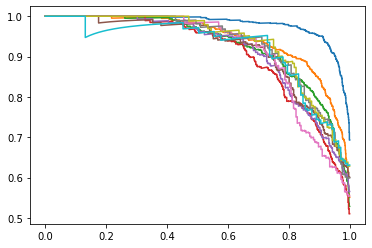

In [42]:
for i in range(1, 11):
    
    exons = kw_comparison_pvals[str(i)].dropna().index
    significant_exons = exons[kw_comparison_pvals.loc[exons, str(i)] <= 0.05]
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_kw = np.array(-kw_comparison_pvals.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_kw)
    plt.plot(rec, pre)

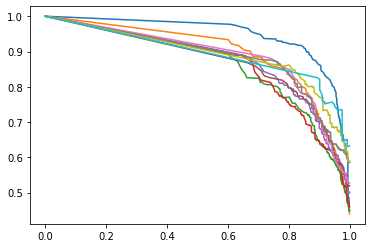

In [43]:
for i in range(1, 11):
    
    exons = psix_comparison_pvals[str(i)].dropna().index
    significant_exons = exons[psix_comparison_pvals.loc[exons, str(i)] <= 0.05]
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_psix = np.array(-psix_comparison_pvals.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_psix)
    plt.plot(rec, pre)

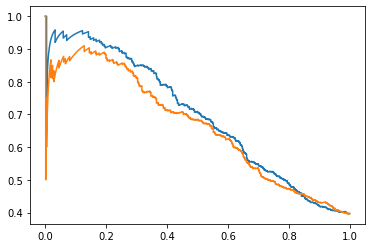

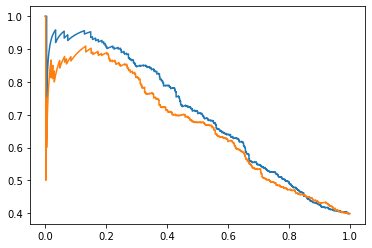

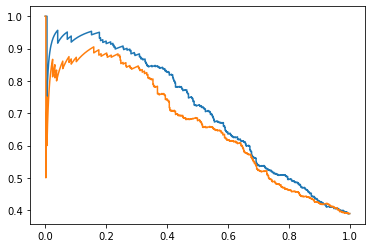

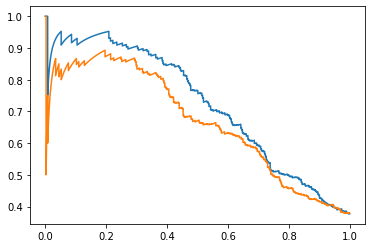

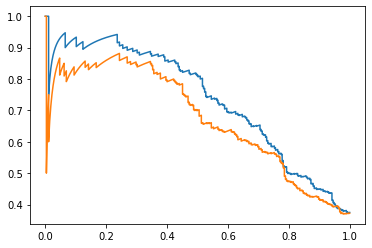

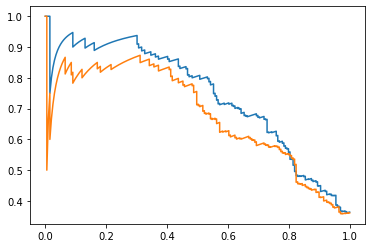

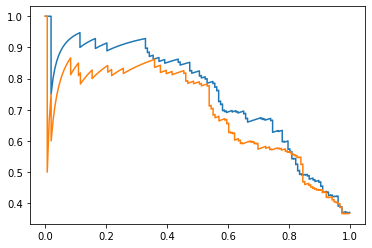

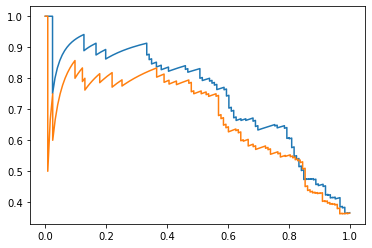

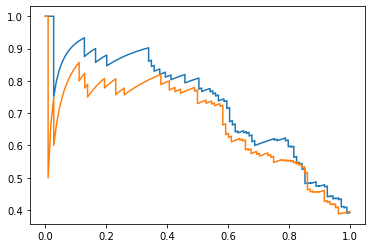

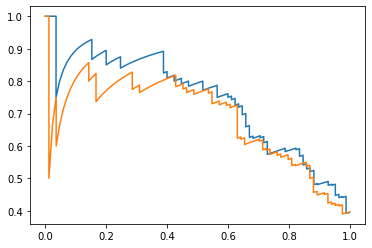

In [36]:
for i in range(1, 11):
    
    exons = psix_comparison_pvals[str(i)].dropna().index & (weyn_pos | weyn_neg)
    significant_exons = weyn_pos & exons
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_psix = np.array(psix_comparison.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_psix)
    plt.plot(rec, pre)
    
    exons = kw_comparison_pvals[str(i)].dropna().index & (weyn_pos | weyn_neg)
    significant_exons = weyn_pos & exons
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_kw = np.array(kw_comparison.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_kw)
    plt.plot(rec, pre)
    
    plt.show()

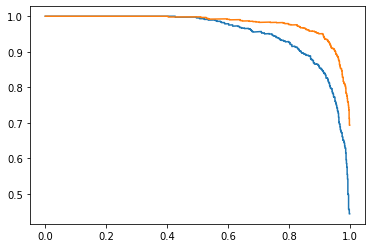

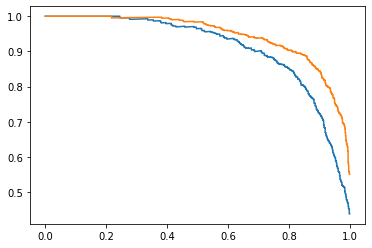

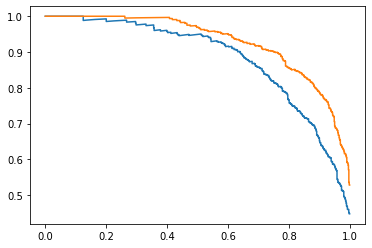

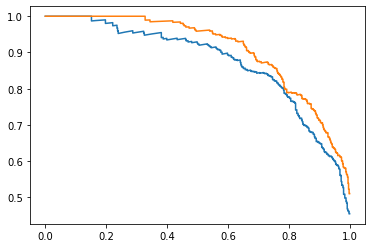

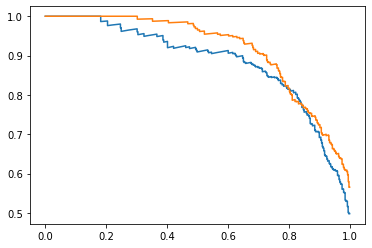

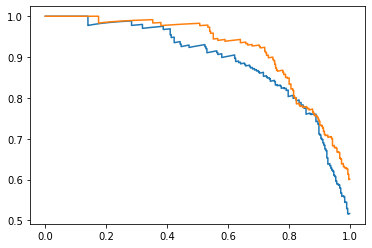

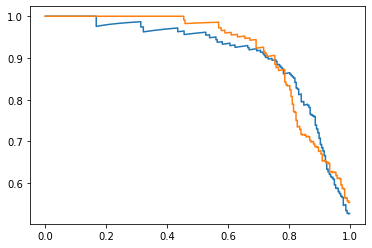

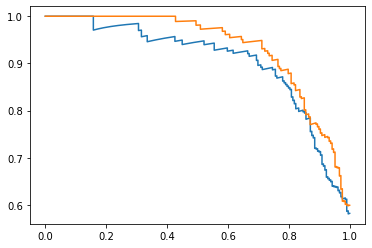

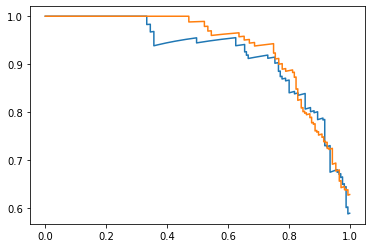

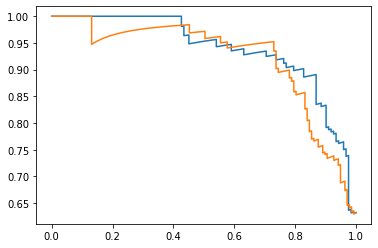

In [30]:
for i in range(1, 11):
    
    exons = psix_comparison_pvals[str(i)].dropna().index
    significant_exons = exons[psix_comparison_pvals.loc[exons, str(i)] <= 0.05]
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_psix = np.array(psix_comparison.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_psix)
    plt.plot(rec, pre)
    
    exons = kw_comparison_pvals[str(i)].dropna().index
    significant_exons = exons[kw_comparison_pvals.loc[exons, str(i)] <= 0.05]
    y_true = [1 if x in significant_exons else 0 for x in exons]
    y_kw = np.array(kw_comparison.loc[exons, '0'])
    pre, rec, thres = precision_recall_curve(y_true, y_kw)
    plt.plot(rec, pre)
    
    plt.show()

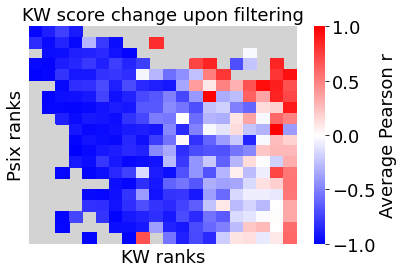

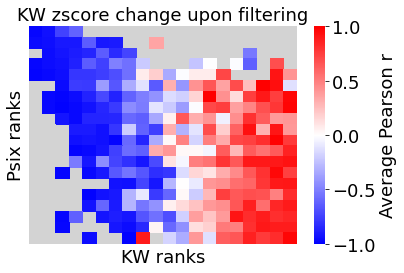

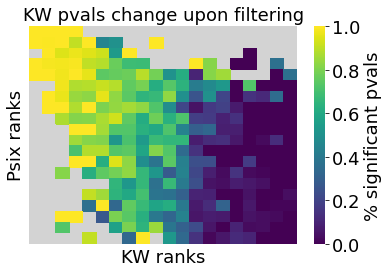

In [9]:
plot_correlations_per_rank(kw_comparison, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='KW score change upon filtering')

plot_correlations_per_rank(kw_comparison_z, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='KW zscore change upon filtering')

plot_correlations_per_rank(kw_comparison_pvals, tiklova_comparison_exons, tiklova_comparison, method = 'pvalues', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='KW pvals change upon filtering')

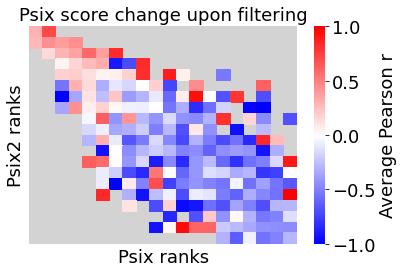

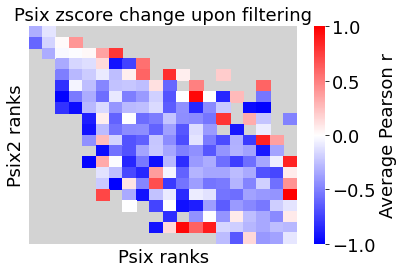

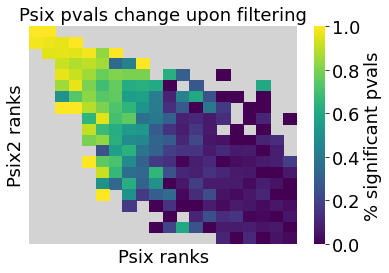

In [46]:
plot_correlations_per_rank(psix_comparison, tiklova_comparison_exons2, tiklova_comparison2, method = 'pearson', 
                               xlabel = 'Psix ranks', ylabel='Psix2 ranks', title='Psix score change upon filtering')

plot_correlations_per_rank(psix_comparison_z, tiklova_comparison_exons2, tiklova_comparison2, method = 'pearson', 
                               xlabel = 'Psix ranks', ylabel='Psix2 ranks', title='Psix zscore change upon filtering')

plot_correlations_per_rank(psix_comparison_pvals, tiklova_comparison_exons2, tiklova_comparison2, method = 'pvalues', 
                               xlabel = 'Psix ranks', ylabel='Psix2 ranks', title='Psix pvals change upon filtering')

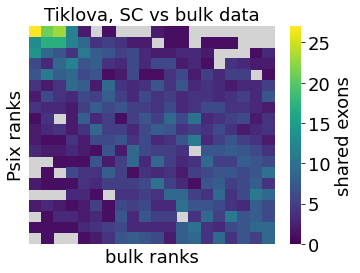

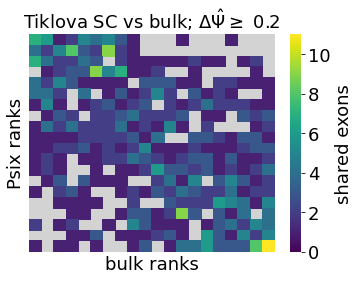

In [48]:
figsize(5.5,4)

comparison, comparison_exons = plot_ranks(weyn_rmats_fdr, tiklova_psix, 'fdr', 'L_score', bins=20, 
                                          name1='bulk ranks', name2='Psix ranks', title='Tiklova, SC vs bulk data')

x = weyn_rmats_fdr.index & weyn_ds.loc[weyn_ds.max(axis=1) >= 0.2].index

figsize(5.5,4)
tb_comparison, tb_comparison_exons = plot_ranks(weyn_rmats_fdr.loc[x], tiklova_psix, 'fdr', 'L_score', bins=20, 
                                          name1='bulk ranks', name2='Psix ranks', 
                                          title='Tiklova SC vs bulk; $\Delta \hat{\Psi} \geq$ 0.2')

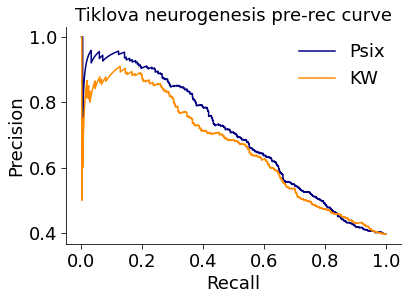

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

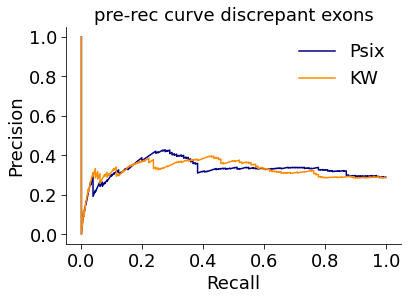

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = psix_only_pos + kw_only_pos
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('pre-rec curve discrepant exons', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)